In [8]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["MUJOCO_GL"] = "egl"

In [10]:
import functools
import json
from datetime import datetime

import jax
import matplotlib.pyplot as plt
import mediapy as media
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax.training import orbax_utils
from IPython.display import clear_output, display
from orbax import checkpoint as ocp

from mujoco_playground import BraxEnvWrapper, manipulation

# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [11]:
env_name = "PandaOrientation"
env_cfg = manipulation.get_default_config(env_name)

In [12]:
SUFFIX = None
FINETUNE_PATH = None

# Generate unique experiment name.
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{env_name}/{timestamp}"
if SUFFIX is not None:
  exp_name += f"-{SUFFIX}"
print(f"Experiment name: {exp_name}")

Experiment name: PandaOrientation/20241109-220331


In [13]:
# policy_sizes = (256,) * 4

# make_networks_factory = functools.partial(
#     ppo_networks.make_ppo_networks,
#     policy_hidden_layer_sizes=policy_sizes) # Half the size of the value network.

make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks, policy_hidden_layer_sizes=(32, 32, 32, 32)
)

In [14]:
ckpt_path = epath.Path("checkpoints").resolve() / exp_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint path: {ckpt_path}")

with open(ckpt_path / "config.json", "w") as fp:
  json.dump(env_cfg.to_dict(), fp, indent=4)


def policy_params_fn(current_step, make_policy, params):
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f"{current_step}"
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)


train_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000,
    num_evals=4,
    reward_scaling=0.1,
    episode_length=150,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=32,
    num_updates_per_batch=8,
    discounting=0.97,
    learning_rate=1e-3,
    entropy_cost=2e-2,
    num_envs=2048,
    batch_size=512,
    num_resets_per_eval=1,
    network_factory=make_networks_factory,
    seed=1,
    policy_params_fn=policy_params_fn,
)

Checkpoint path: /home/andrew/Documents/Projects/2024-mujoco/mujoco_playground/learning/checkpoints/PandaOrientation/20241109-220331


Training at 211480.60792867164 FPS


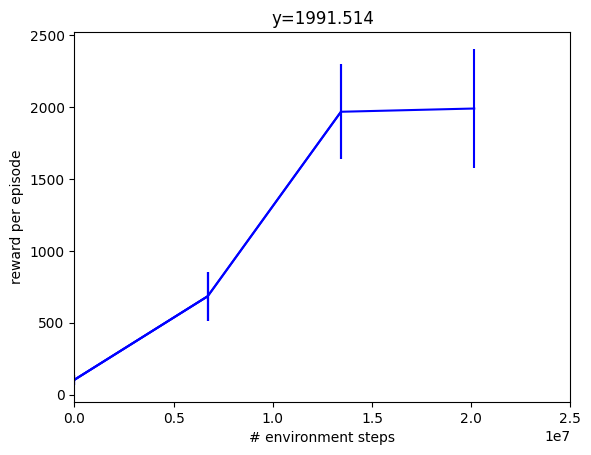

time to jit: 0:00:31.316263
time to train: 0:01:54.514882


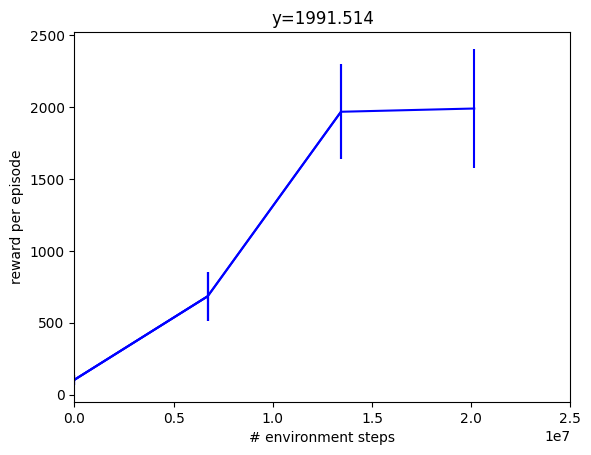

In [15]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  # Plot.
  clear_output(wait=True)
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  # Performance.
  if len(x_data) >= 2:
    num = x_data[-1] - x_data[-2]
    denom = (times[-1] - times[-2]).total_seconds()
    fps = num / denom
    print(f"Training at {fps} FPS")

  plt.xlim([0, train_fn.keywords["num_timesteps"] * 1.25])
  # plt.ylim([0, YLIM[env_name]])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())


env = manipulation.load(env_name, config=env_cfg)
eval_env = manipulation.load(env_name, config=env_cfg)
make_inference_fn, params, _ = train_fn(
    environment=BraxEnvWrapper(env),
    progress_fn=progress,
    eval_env=BraxEnvWrapper(eval_env),
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [16]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [21]:
key = jax.random.PRNGKey(0)
key, key_reset = jax.random.split(key)
state = jit_reset(key_reset)
states = [state]

render_every = 2  # Policy is 50 FPS

for i in range(150):
  act_rng, key = jax.random.split(key)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  if i % render_every == 0:
    states.append(state)

media.show_video(
    env.render_with_target(states), fps=1.0 / env.dt / render_every
)

100%|██████████| 76/76 [00:00<00:00, 969.35it/s]
